In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import h5py
import argparse
import pickle
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

print('Tensorflow version ' + tf.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow version 2.4.1
/kaggle/input/dataset-course/Dataset Course 200 perm.h5
/kaggle/input/dataset-course/Dataset Course logk residual.h5
/kaggle/input/dataset-course/Dataset Course.h5


# 连接tpu，并将模型放在tpu上训练，能极大的提升网络的训练速度

In [20]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print(tpu)
    print(strategy)
    # print(strategy.num_replicas_in_sync)
except ValueError:
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
    
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [21]:
parser = argparse.ArgumentParser(description='Rucurrent_R_U_Net')
parser.add_argument('--epoch', type=int, default=80, help='the number of epochs to train')
parser.add_argument('--batch_size', type=int, default=30)
parser.add_argument('--data_format', type=str, default='channels_last')
parser.add_argument('--regularizer_weight', type=float, default=0, help='the regularization coefficient')
args = parser.parse_known_args()[0]

print('---------------------Arguments----------------------')
for k, v in sorted(vars(args).items()):
    print('%s: %s' % (str(k), str(v)))
print('------------------------End-------------------------')

---------------------Arguments----------------------
batch_size: 30
data_format: channels_last
epoch: 80
regularizer_weight: 0
------------------------End-------------------------


# Define network model 

In [22]:
from keras import backend as K
from keras import regularizers, Sequential, Model
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import ReLU, BatchNormalization, TimeDistributed, Input


class Conv_block(Sequential):
    def __init__(self, output_features=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Conv_block, self).__init__()

        self.add(Conv2D(output_features, kernel_size, strides, padding, data_format,
                        kernel_regularizer=regularizers.l2(regularizer_weight)))
        # padding='same', H_out = ceil(H/s)
        # padding='valid', H_out = ceil(H-k+1/s)

        self.add(BatchNormalization())
        self.add(ReLU())


class Time_Conv_block(Sequential):
    def __init__(self, output_features=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Time_Conv_block, self).__init__()
        self.add(TimeDistributed(Conv2D(output_features, kernel_size, strides, padding, data_format,
                                        kernel_regularizer=regularizers.l2(regularizer_weight))))
        self.add(TimeDistributed(BatchNormalization()))
        self.add(TimeDistributed(ReLU()))


class Residual_block(Sequential):
    def __init__(self, output_features=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Residual_block, self).__init__()
        self.add(Conv2D(output_features, kernel_size, strides, padding, data_format,
                        kernel_regularizer=regularizers.l2(regularizer_weight)))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Conv2D(output_features, kernel_size, strides, padding, data_format,
                        kernel_regularizer=regularizers.l2(regularizer_weight)))
        self.add(BatchNormalization())

    def call(self, inputs, training=None, mask=None):
        outputs = super(Residual_block, self).call(inputs)
        return outputs + inputs


class Time_Residual_block(Sequential):
    def __init__(self, output_features=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Time_Residual_block, self).__init__()
        self.add(TimeDistributed(Conv2D(output_features, kernel_size, strides, padding, data_format,
                                        kernel_regularizer=regularizers.l2(regularizer_weight))))
        self.add(TimeDistributed(BatchNormalization()))
        self.add(TimeDistributed(ReLU()))
        self.add(TimeDistributed(Conv2D(output_features, kernel_size, strides, padding, data_format,
                                        kernel_regularizer=regularizers.l2(regularizer_weight))))
        self.add(TimeDistributed(BatchNormalization()))

    def call(self, inputs, training=None, mask=None):
        outputs = super(Time_Residual_block, self).call(inputs)
        return outputs+inputs


class Transposed_conv_block(Sequential):
    def __init__(self, output_features=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 output_padding=None, data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Transposed_conv_block, self).__init__()

        self.add(Conv2DTranspose(output_features, kernel_size, strides, padding, output_padding, data_format,
                                 kernel_regularizer=regularizers.l2(regularizer_weight)))
        # theoretical formula, H_out = s(H-1)+k-2p+output_padding
        # padding='same', H_out = s*H+output_padding
        # padding='valid', H_out = s(H-1)+k+output_padding

        self.add(Conv2D(output_features, kernel_size, (1, 1), padding, data_format,
                        kernel_regularizer=regularizers.l2(regularizer_weight)))
        self.add(BatchNormalization())
        self.add(ReLU())


class Time_Transposed_conv_block(Sequential):
    def __init__(self, output_features=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 output_padding=None, data_format='channels_last', regularizer_weight=args.regularizer_weight):
        super(Time_Transposed_conv_block, self).__init__()
        self.add(TimeDistributed(Conv2DTranspose(output_features, kernel_size, strides, padding, output_padding,
                                                 data_format, kernel_regularizer=regularizers.l2(regularizer_weight))))
        self.add(TimeDistributed(Conv2D(output_features, kernel_size, (1, 1), padding, data_format,
                                        kernel_regularizer=regularizers.l2(regularizer_weight))))
        self.add(TimeDistributed(BatchNormalization()))
        self.add(TimeDistributed(ReLU()))


class Repeat_conv(Layer):
    """Repeats the input n times.
    # Example
    ```python
        model = Sequential()
        model.add(Dense(32, input_dim=32))
        # now: model.output_shape == (None, 32)
        # note: `None` is the batch dimension
        model.add(RepeatVector(3))
        # now: model.output_shape == (None, 3, 32)
    ```
    # Arguments
        n: integer, repetition factor.
    # Input shape
        4D tensor of shape `(num_samples, w, h, c)`.
    # Output shape
        5D tensor of shape `(num_samples, n, w, h, c)`.
    """
    def __init__(self, n, **kwargs):
        super(Repeat_conv, self).__init__(**kwargs)
        self.n = n
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.n, input_shape[1], input_shape[2], input_shape[3]

    def call(self, inputs):
        x = K.expand_dims(inputs, axis=1)
        pattern = tf.stack([1, self.n, 1, 1, 1])
        return K.tile(x, pattern)

    def get_config(self):
        config = {'n': self.n}
        base_config = super(Repeat_conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# class Recurrent_R_U_Net(Sequential):
#     def __init__(self, input_shape, time_step=8, data_format='channels_last'):
#         super(Recurrent_R_U_Net, self).__init__()
#         self.time_step = time_step

#         # -------------Encoder--------------
#         self.add(Input(shape=input_shape, name='image'))
#         self.add(Conv_block(output_features=16, strides=(2, 2), data_format=data_format))
#         # data_format='same', H_out = ceil(H/s)
#         # data_format='valid', H_out = ceil(H-k+1/s)
#         self.add(Conv_block(output_features=32, strides=(1, 1), data_format=data_format))
#         self.add(Conv_block(output_features=64, strides=(2, 2), data_format=data_format))
#         self.add(Conv_block(output_features=128, strides=(1, 1), data_format=data_format))

#         # all the Residual block are the same
#         for i in range(3):
#             self.add(Residual_block(data_format=data_format))

#         self.add(Repeat_conv(self.time_step))
#         self.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
#                             data_format=data_format, activation='tanh', recurrent_activation='hard_sigmoid',
#                             use_bias=True, return_sequences=True, dropout=False, recurrent_dropout=False))

#         # ----------------Decoder---------------
#         time_res_conv1 = Time_Residual_block(data_format=data_format)
#         time_res_conv2 = Time_Residual_block(data_format=data_format)
#         time_res_conv3 = Time_Residual_block(data_format=data_format)

#         for i in range(3):
#             self.add(Time_Residual_block(data_format=data_format))

#         self.add(Time_Transposed_conv_block(output_features=128, kernel_size=(3, 3), strides=(1, 1), data_format=data_format))
#         self.add(Time_Transposed_conv_block(output_features=64, kernel_size=(3, 3), strides=(2, 2), data_format=data_format))
#         self.add(Time_Transposed_conv_block(output_features=32, kernel_size=(3, 3), strides=(1, 1), data_format=data_format))
#         self.add(Time_Transposed_conv_block(output_features=16, kernel_size=(3, 3), strides=(2, 2), data_format=data_format))
#         self.add(Time_Conv_block(output_features=1, data_format=data_format))

        
class Recurrent_R_U_Net(Model):
    def __init__(self, input_shape, time_step=8, data_format='channels_last'):
        super(Recurrent_R_U_Net, self).__init__()
        self.time_step = time_step

        # -------------Encoder--------------
#         self.add(Input(shape=input_shape, name='image'))
        self.conv1 = Conv_block(output_features=16, strides=(2, 2), data_format=data_format)
        self.conv2 = Conv_block(output_features=32, strides=(1, 1), data_format=data_format)
        self.conv3 = Conv_block(output_features=64, strides=(2, 2), data_format=data_format)
        self.conv4 = Conv_block(output_features=128, strides=(1, 1), data_format=data_format)
        
        # all the Residual block are the same
        self.res_conv1 = Residual_block(data_format=data_format)
        self.res_conv2 = Residual_block(data_format=data_format)
        self.res_conv3 = Residual_block(data_format=data_format)
        
        self.repeat_conv = Repeat_conv(self.time_step)
        self.ConvLSTM = ConvLSTM2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                            data_format=data_format, activation='tanh', recurrent_activation='hard_sigmoid',
                            use_bias=True, return_sequences=True, dropout=False, recurrent_dropout=False)
    
        # ----------------Decoder---------------
        self.time_res_conv1 = Time_Residual_block(data_format=data_format)
        self.time_res_conv2 = Time_Residual_block(data_format=data_format)
        self.time_res_conv3 = Time_Residual_block(data_format=data_format)
        
        self.time_t_conv1 = Time_Transposed_conv_block(output_features=128, kernel_size=(3, 3), strides=(1, 1), data_format=data_format)
        self.time_t_conv2 = Time_Transposed_conv_block(output_features=64, kernel_size=(3, 3), strides=(2, 2), data_format=data_format)
        self.time_t_conv3 = Time_Transposed_conv_block(output_features=32, kernel_size=(3, 3), strides=(1, 1), data_format=data_format)
        self.time_t_conv4 = Time_Transposed_conv_block(output_features=16, kernel_size=(3, 3), strides=(2, 2), data_format=data_format)
        self.time_t_conv5 = Time_Conv_block(output_features=1, data_format=data_format)
    
    def call(self, inputs, training=None, mask=None):
        enc1 = self.conv1(inputs)  # (40, 40, 16)
        time_enc1 = self.repeat_conv(enc1)  # (time_step, 40, 40, 16)
        enc2 = self.conv2(enc1)  # (40, 40, 32)
        time_enc2 = self.repeat_conv(enc2)  # (time_step, 40, 40, 32)
        enc3 = self.conv3(enc2)  # (20, 20, 64)
        time_enc3 = self.repeat_conv(enc3)  # (time_step, 20, 20, 64)
        enc4 = self.conv4(enc3)  # (20, 20, 128)
        time_enc4 = self.repeat_conv(enc4)  # (time_step, 20, 20, 128)
        
        x = self.res_conv1(enc4)  # (20, 20, 128)
        x = self.res_conv2(x)  # (20, 20, 128)
        x = self.res_conv3(x)  # (20, 20, 128)
        
        x = Repeat_conv(self.time_step)(enc4)  # (time_step, 20, 20, 128)
        x = self.ConvLSTM(x)  # (time_step, 20, 20, 128)
        
        x = self.time_res_conv1(x)  # (time_step, 20, 20, 128)
        x = self.time_res_conv2(x)  # (time_step, 20, 20, 128)
        dec4 = self.time_res_conv3(x)  # (time_step, 20, 20, 128)
        
        merge4 = tf.concat([time_enc4, dec4], -1)  # (time_step, 20, 20, 128+128)
        dec3 = self.time_t_conv1(merge4)  # (time_step, 20, 20, 128)
        merge3 = tf.concat([time_enc3, dec3], -1)  # (time_step, 20, 20, 64+128)  
        dec2 = self.time_t_conv2(merge3)  # (time_step, 40, 40, 64)  
        merge2 = tf.concat([time_enc2, dec2], -1)  # (time_step, 40, 40, 32+64)  
        dec1 = self.time_t_conv3(merge2)  # (time_step, 40, 40, 32)  
        merge1 = tf.concat([time_enc1, dec1], -1)  # (time_step, 40, 40, 16+32)  
        dec0 = self.time_t_conv4(merge1)  # (time_step, 80, 80, 16)  
        output = self.time_t_conv5(dec0)  # (time_step, 80, 80, 1)  
    
        return output
        
        
x = Input(shape=(80, 80, 3))
model = Recurrent_R_U_Net(input_shape=(80, 80, 3), time_step=10, data_format='channels_last')
y = model(x)
print(y.shape)
model.summary()


# Conv_2D = tf.keras.layers.Conv2D(64, 3)
# y = TimeDistributed(Conv_block())(x)
# print(y.shape)
# y = y.numpy()
# for i in range(19):
#     print(y[0, i].any() == y[0, i+1].any())

(None, 10, 80, 80, 1)
Model: "recurrent_r_u__net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_8 (Conv_block)    (None, 40, 40, 16)        512       
_________________________________________________________________
conv_block_9 (Conv_block)    (None, 40, 40, 32)        4768      
_________________________________________________________________
conv_block_10 (Conv_block)   (None, 20, 20, 64)        18752     
_________________________________________________________________
conv_block_11 (Conv_block)   (None, 20, 20, 128)       74368     
_________________________________________________________________
residual_block_6 (Residual_b (None, 20, 20, 128)       296192    
_________________________________________________________________
residual_block_7 (Residual_b (None, 20, 20, 128)       296192    
_________________________________________________________________
residual_block_8 (Residu

In [23]:
# print(os.getcwd())
# print(os.listdir(os.getcwd()))
# # output_directory = r'./results_2021.04.10'
# # if not os.path.exists(output_directory):
# #     os.mkdir(output_directory)  

# os.remove(r'kaggle/working/__notebook_source__.ipynb')
# # os.rmdir(output_directory)
# print(os.listdir(os.getcwd()))

In [24]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# user_credential = user_secrets.get_gcloud_credential()
# user_secrets.set_tensorflow_credential(user_credential)
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()
# print(GCS_DS_PATH)

In [25]:
# 含水饱和度Sw
# with h5py.File(r'../input/dataset-course/Dataset Course.h5', 'r') as f:
#     x_train = f['train_input'][()]
#     y_train = f['train_output'][:, :, :, :, :1]
#     x_test = f['test_input'][()]
#     y_test = f['test_output'][:, :, :, :, :1]

#  地层压力P
# with h5py.File(r'../input/dataset-course/Dataset Course.h5', 'r') as f:
#     x_train = f['train_input'][()]
#     y_train = f['train_output'][:, :, :, :, 1:] 
#     x_test = f['test_input'][()]
#     y_test = f['test_output'][:, :, :, :, 1:]  

#  残差学习，含水饱和度Sw
with h5py.File(r'../input/dataset-course/Dataset Course logk residual.h5', 'r') as f:
    x_train = f['train_input'][()]
    y_train = f['train_output'][:, :, :, :, :1]
    x_test = f['test_input'][()]
    y_test = f['test_output'][:, :, :, :, :1]
    initial = f['test_output'][:, :, :, :, 1:2]
    
#  残差学习，地层压力P
# with h5py.File(r'../input/dataset-course/Dataset Course logk residual.h5', 'r') as f:
#     x_train = f['train_input'][()]
#     y_train = f['train_output'][:, :, :, :,2:3]
#     x_test = f['test_input'][()]
#     y_test = f['test_output'][:, :, :, :, 2:3]
#     initial = f['test_output'][:, :, :, :, 3:]
    
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(180, 80, 80, 1)
(180, 10, 80, 80, 1)
(20, 80, 80, 1)
(20, 10, 80, 80, 1)


In [26]:
#  define the loss for Recurrent_R_U_Net
def l2_loss(y_true, y_pred):
    return K.sum((K.batch_flatten(y_true)-K.batch_flatten(y_pred))**2, axis=-1)


def l2_mean_loss(y_true, y_pred):
    return K.mean(l2_loss(y_true, y_pred))


def l1_loss(y_true, y_pred):
    return K.sum(K.abs(K.batch_flatten(y_true)-K.batch_flatten(y_pred)), axis=-1)


def l1_mean_loss(y_true, y_pred):
    return K.mean(l1_loss(y_true, y_pred))


def relative_l1_loss(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / y_true))

In [27]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = Recurrent_R_U_Net(input_shape=(80, 80, 1), time_step=10, data_format=args.data_format)

    model.compile(loss=l1_mean_loss, optimizer=tf.keras.optimizers.Adam(lr=3e-3), metrics=[relative_l1_loss])
    scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15, cooldown=1, verbose=1, min_lr=1e-6)
    checkpoint = ModelCheckpoint(r'./saved-model-{epoch:03d}-{val_loss:.5f}.h5', monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='auto')
    callback_list = [scheduler, checkpoint]
    
start = time()
history = model.fit(x_train, y_train, batch_size=args.batch_size, epochs=args.epoch, verbose=1,
                    validation_data=(x_test, y_test), callbacks=callback_list)
end = time()
print('the training time is:', end-start)

model.save_weights(r'./trained_model.h5')
# model.load_weights()

# save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(r'./trained_model.h5', options=save_locally)
# model.save(GCS_DS_PATH + r'/trained_model_no_options')
# model.save(r'./trained_model', options=save_locally)

Epoch 1/80
6/6 [==============================] - 12s 874ms/step - loss: 18174.1720 - relative_l1_loss: nan - val_loss: 2873799168.0000 - val_relative_l1_loss: nan

Epoch 00001: val_loss improved from inf to 2873799168.00000, saving model to ./saved-model-001-2873799168.00000.h5
Epoch 2/80
6/6 [==============================] - 2s 386ms/step - loss: 5574.1240 - relative_l1_loss: nan - val_loss: 998639616.0000 - val_relative_l1_loss: nan

Epoch 00002: val_loss improved from 2873799168.00000 to 998639616.00000, saving model to ./saved-model-002-998639616.00000.h5
Epoch 3/80
6/6 [==============================] - 2s 386ms/step - loss: 1678.9930 - relative_l1_loss: nan - val_loss: 349015136.0000 - val_relative_l1_loss: nan

Epoch 00003: val_loss improved from 998639616.00000 to 349015136.00000, saving model to ./saved-model-003-349015136.00000.h5
Epoch 4/80
6/6 [==============================] - 2s 386ms/step - loss: 695.2662 - relative_l1_loss: nan - val_loss: 61386516.0000 - val_relative

# 残差学习时，第二个图可能会报错。原因：有些分母非常小，导致relative_l1_loss有些值不存在，进而影响整个relative_l1_loss

ValueError: Axis limits cannot be NaN or Inf

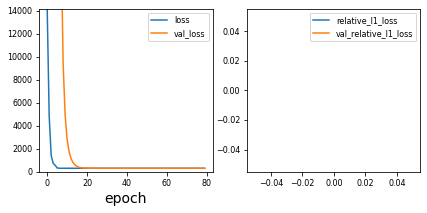

In [39]:
with open(r'./loss_during_model_training.pickle', 'wb') as f:
    pickle.dump(history.history, f)

    
# plot the loss of Recurrent_R_U_Net during the training epoch
rc = {"font.family": "Arial",
      "mathtext.fontset": "custom",
      "mathtext.rm": "Arial",
      "mathtext.it": "Arial:italic",
      "mathtext.bf": "Arial:bold",
      'font.size': 8,
      }
plt.rcParams.update(rc)

plt.figure(figsize=(6.83, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', fontsize=8)
plt.ylim(0, np.max(history.history['loss']))
plt.xlabel('epoch', {'size': 14})

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(history.history['relative_l1_loss'])), history.history['relative_l1_loss'], label='relative_l1_loss')
plt.plot(np.arange(len(history.history['val_relative_l1_loss'])), history.history['val_relative_l1_loss'], label='val_relative_l1_loss')
plt.legend(loc='upper right', fontsize=8)
plt.ylim(0, np.max(history.history['relative_l1_loss']))
plt.xlabel('epoch', {'size': 14})
plt.savefig(r'./loss.png', dpi=600, bbox_inches='tight')
plt.show()

In [29]:
Predictions = model.predict(x_test)

with h5py.File('Sw.h5', 'w') as f:
    f.create_dataset('Sw', data=Predictions, compression='gzip') 
    
# with h5py.File('Pressure.h5', 'w') as f:
#     f.create_dataset('Pressure', data=Predictions, compression='gzip') 

15


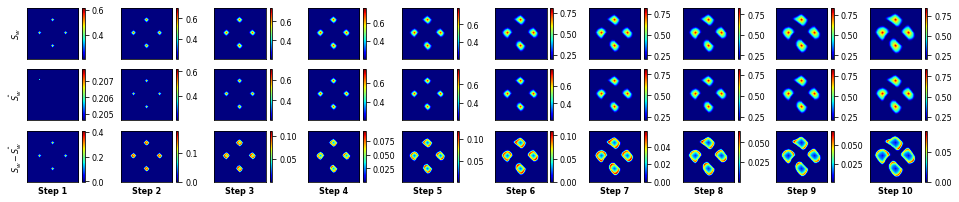

In [38]:
#  残差学习画图
column = Predictions.shape[1]
m = np.random.randint(0, Predictions.shape[0])
print(m)

fig = plt.figure(figsize=(1.65*column, 3.2))
for i in range(column):
    if i==0:
        ax = fig.add_subplot(3, column, i+1)
        sc = ax.imshow(y_test[m, i]+initial[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('$S_w$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
        plt.colorbar(sc)

        ax = fig.add_subplot(3, column, column+i+1)
        sc = ax.imshow(Predictions[m, i]+initial[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('$\hat{S_w}$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
        plt.colorbar(sc)

        ax = fig.add_subplot(3, column, 2*column +i+1)
        sc = ax.imshow(y_test[m, i]-Predictions[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('Step {}'.format(i+1), {'family': 'Arial', 'weight': 'bold', 'size': 8})
        ax.set_ylabel('$S_w-\hat{S_w}$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
        plt.colorbar(sc)
        
    else:
        ax = fig.add_subplot(3, column, i+1)
        sc = ax.imshow(y_test[m, i]+initial[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(sc)

        ax = fig.add_subplot(3, column, column+i+1)
        sc = ax.imshow(Predictions[m, i]+initial[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(sc)

        ax = fig.add_subplot(3, column, 2*column +i+1)
        sc = ax.imshow(y_test[m, i]-Predictions[m, i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('Step {}'.format(i+1), {'family': 'Arial', 'weight': 'bold', 'size': 8})
        plt.colorbar(sc)
        
plt.savefig('Image.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# column = Predictions.shape[1]
# m = np.random.randint(0, Predictions.shape[0])
# print(m)

# fig = plt.figure(figsize=(1.65*column, 3.2))
# for i in range(column):
#     if i==0:
#         ax = fig.add_subplot(3, column, i+1)
#         sc = ax.imshow(y_test[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_ylabel('$S_w$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
#         plt.colorbar(sc)

#         ax = fig.add_subplot(3, column, column+i+1)
#         sc = ax.imshow(Predictions[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_ylabel('$\hat{S_w}$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
#         plt.colorbar(sc)

#         ax = fig.add_subplot(3, column, 2*column +i+1)
#         sc = ax.imshow(y_test[m, i]-Predictions[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel('Step {}'.format(i+1), {'family': 'Arial', 'weight': 'bold', 'size': 8})
#         ax.set_ylabel('$S_w-\hat{S_w}$', {'family': 'Arial', 'weight': 'bold', 'size': 8})
#         plt.colorbar(sc)
        
#     else:
#         ax = fig.add_subplot(3, column, i+1)
#         sc = ax.imshow(y_test[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.colorbar(sc)

#         ax = fig.add_subplot(3, column, column+i+1)
#         sc = ax.imshow(Predictions[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.colorbar(sc)

#         ax = fig.add_subplot(3, column, 2*column +i+1)
#         sc = ax.imshow(y_test[m, i]-Predictions[m, i], cmap='jet')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel('Step {}'.format(i+1), {'family': 'Arial', 'weight': 'bold', 'size': 8})
#         plt.colorbar(sc)
        
# plt.savefig('Image.png', dpi=600, bbox_inches='tight')
# plt.show()